In [1]:
from autograd import grad, numpy as np
from scipy import special
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import skimage, skimage.transform, skimage.data
import skimage.feature, skimage.restoration
import optimize

In [2]:
def getAiryProbe(wavelength=0.142e-9, # 8.7 keV 
                 pixel_pitch=55e-6, # 55 micrometers 
                 npix=64,
                 n_photons=1e6,
                 beam_diam_pixels=20):
    """Calculates the beam profile given the final beam diameter. 
    
    Parameters:
    
    wavelength : 
    self-explanatory
    
    pixel_pitch : 
    object/probe pixel pitch. Usually calculated using the Nyquist theorem using the object-detector
    distance and the detector pixel pitch.
    
    n_pix:
    number of pixels along each axis in the probe view
    
    n_photons:
    self-explanatory
    
    beam_diam_pixels:
    the diameter (in pixels) of the first central lobe of the probe beam at the object (sample) plane.

    Assumption:
    - propagation distance (from aperture to sample) and initial aperture width are calculated 
    assuming a Fresnel number of 0.1
    """
    beam_width_dist = beam_diam_pixels * pixel_pitch
    radius = beam_width_dist / 2
    # Initial Aperture width
    w = 0.1 * 2 * np.pi * radius / (special.jn_zeros(1, 1))
    
    # Propagation dist from aperture to sample
    z = 0.1 * (2 * np.pi * radius)**2 / (special.jn_zeros(1, 1)**2 * wavelength)
    
    beam_center = npix // 2
    xvals = np.linspace( -beam_center * pixel_pitch, beam_center * pixel_pitch, npix)
    xx, yy = np.meshgrid(xvals, xvals)
    

    k = 2 * np.pi / wavelength
    lz = wavelength * z
    S = xx**2 + yy**2

    jinc_input = np.sqrt(S) * w / lz
    mask = (jinc_input != 0)
    jinc_term = np.pi * np.ones_like(jinc_input)
    jinc_term[mask] = special.j1(jinc_input[mask] * 2 * np.pi) / jinc_input[mask]

    # wavefield 
    term1 = np.exp(1j * k * z) / (1j * lz)
    term2 = np.exp(1j * k * S / (2 * z))
    term3 = w**2 * jinc_term
    field_vals = (term1 * term2 * term3).astype('complex64')

    scaling_factor = np.sqrt(n_photons / (np.abs(field_vals)**2).sum())
    field_vals = scaling_factor * field_vals
    return field_vals

In [3]:
def getSampleObj(npix=256, mod_range=1, phase_range=np.pi):
    """Creates a sample object using stock data from the skimage module.
    
    Parameters:
    npix - 
    Number of pixels in each axis of the object
    
    mod_range - 
    Maximum value of the modulus for the object pixels.
    
    phase_range - 
    Maximum value of the phase for the object pixels.
    """
    mod_img = skimage.img_as_float(skimage.data.camera())[::-1,::-1]
    phase_img = skimage.img_as_float(skimage.data.immunohistochemistry()[:,:,0])[::-1,::-1]
    mod = skimage.transform.resize(mod_img, [npix, npix], 
                                   mode='wrap', preserve_range=True) * mod_range
    phase = skimage.transform.resize(phase_img, [npix,npix],
                                     mode='wrap', preserve_range=True) * phase_range
    return mod * np.exp(1j * phase)

In [4]:
def removePlaneFitFromPhase(test_phase):
    """Fits a plane to the phase.
    
    Unwraps the phase before the fitting procedure to remove the discontinuities at -pi <-> pi
    """
    b = skimage.restoration.unwrap_phase(test_phase).flatten()
    X = np.arange(test_phase.shape[1])
    Y = np.arange(test_phase.shape[0])
    XX, YY = np.meshgrid(X, Y)
    a = np.vstack((np.ones(XX.size), XX.flatten(), YY.flatten())).T
    
    params, residuals, rank, s = np.linalg.lstsq(a, b)
    phase_new = (b - a @ params).reshape(test_phase.shape)
    return phase_new

In [5]:
def registerImages(true_img, test_img):
    """When reconstucting both the object and the probe, the phase contains two kinds of artefacts:
    
    1) global phase shift.
    2) gradient in the phase with respect to the x and y axes. The gradient in the object phase
    is equal and opposite in sign to the gradient in the probe phase.
    
    By fitting a plane to the phase, we can remove both kinds of artefacts at once. 
    
    The true object might itself contain a gradient in the phase - I have to remove
    this gradient as well before I do a subpixel registration.
    """
    true_img_abs = np.abs(true_img)
    true_img_phase = np.angle(true_img)
    
    test_img_abs = np.abs(test_img)
    test_img_phase = np.angle(test_img)
    
    pix_shift, err, _ = skimage.feature.register_translation(true_img_abs, test_img_abs, upsample_factor=10)
    pix_shift = pix_shift.astype('int')
    test_img_rolled_abs = np.roll(test_img_abs, pix_shift, axis=(0,1))
    test_img_rolled_phase = np.roll(test_img_phase, pix_shift, axis=(0,1))
    
    true_img_phase_fitted = removePlaneFitFromPhase(true_img_phase)
    test_img_phase_fitted = removePlaneFitFromPhase(test_img_rolled_phase)
    
    true_img_new = true_img_abs * np.exp(1j * true_img_phase_fitted)
    test_img_new = test_img_rolled_abs * np.exp(1j * test_img_phase_fitted)
    
    pix_shift, err, phase_shift = skimage.feature.register_translation(true_img_new, test_img_new, upsample_factor=10)
    return [true_img_new, test_img_new], [pix_shift, err, phase_shift]

## Generating the object, the probe, and the diffraction intensities (with Poisson noise) ##

In [6]:
# Generating the object and the probe. 
# For convenience, I am not setting the detector pixel pitch - just working directly with the object plane 
obj_npix = 128
probe_npix = 64
n_photons = 1e6
beam_diam_pixels = 40
probe_true = getAiryProbe(n_photons=n_photons, npix=probe_npix, beam_diam_pixels=beam_diam_pixels)
obj_true = getSampleObj(npix=obj_npix)


In [7]:
# Generating diffraction patterns for the given number of scan points (in a square grid)
# Calculates the position so that the probe view always fits inside the object dimensions.
num_scan_steps_x = 12
grid_positions = np.floor(np.linspace(0, obj_npix - probe_npix, num_scan_steps_x)).astype('int')

diff_intensities = []
positions = []

for y in grid_positions:
    for x in grid_positions:
        exit_wave = obj_true[y: y + probe_npix, x: x + probe_npix] * probe_true
        exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave, norm='ortho'))
        diff_temp = np.abs(exit_wave_ft)**2
        diff_intensities.append(diff_temp)
        positions.append([x,y])
        
diff_intensites = np.array(diff_intensities)
# Adding poisson noise
diff_intensities = np.random.poisson(diff_intensities)

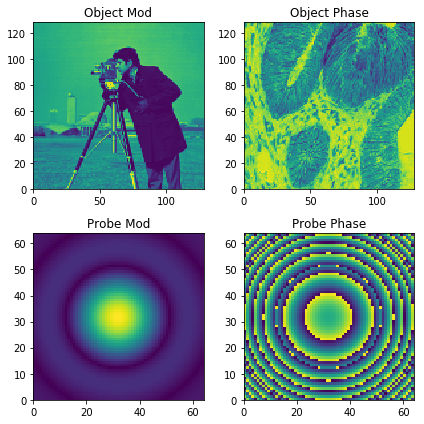

In [8]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(obj_true), np.angle(obj_true), np.abs(probe_true), np.angle(probe_true)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item)
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

In [17]:
def loss(obj_guess_flat):
    minibatch_size = 5
    minibatch = np.random.choice(np.shape(positions)[0], size=minibatch_size)
    obj_guess = obj_guess_flat.reshape(obj_true.shape)
    losses_sum = 0
    for indx in minibatch:
        r, c = positions[indx]
        this_diff = diff_intensites[indx]
        exit_wave = obj_guess[r: r + probe_npix, c: c + probe_npix] * probe_true
        exit_wave_ft = np.fft.fftshift(np.fft.fft2(exit_wave, norm='ortho'))
        
        loss_this = np.mean((np.sqrt(this_diff) - np.abs(exit_wave_ft))**2)
        losses_sum += loss_this
    return losses_sum / minibatch_size

In [18]:
obj_guess_flat = (np.random.random(obj_true.shape) * np.exp(1j * np.pi * np.random.random(obj_true.shape))).flatten()

In [19]:
loss_grad = lambda obj_guess_flat: np.conjugate(grad(loss)(obj_guess_flat)) 

In [24]:
loss(obj_guess_flat)

48.62023210130468

In [48]:
xopt = obj_guess_flat.copy()
for i in range(10):
    xopt = optimize.fmin_cg(f=loss, x0=xopt, fprime=loss_grad, maxiter=20)
    mask = np.abs(xopt) > 1
    xopt[mask] = xopt[mask] / np.abs(xopt[mask])
    

         Current function value: 8.297629
         Iterations: 2
         Function evaluations: 28
         Gradient evaluations: 20
         Current function value: 7.095582
         Iterations: 1
         Function evaluations: 19
         Gradient evaluations: 9
         Current function value: 5.808789
         Iterations: 9
         Function evaluations: 61
         Gradient evaluations: 52
         Current function value: 5.313005
         Iterations: 20
         Function evaluations: 107
         Gradient evaluations: 107


KeyboardInterrupt: 

In [46]:
optimize.fmin_cg(f=loss, x0=xopt, fprime=loss_grad, maxiter=100, gtol=1e-8)

         Current function value: 7.095582
         Iterations: 1
         Function evaluations: 19
         Gradient evaluations: 9


array([0.78901053+0.16806456j, 0.39853888+0.30163685j,
       0.04270046+0.16653265j, ..., 0.07117006+0.08427068j,
       0.04862452+0.35767866j, 0.00815278+0.01121991j])

## Tensorflow reconstruction ##

In [65]:
# Initialize the probe with a backpropagation
# Random initalization for the object
probe_init = np.fft.fftshift(np.fft.ifft2(np.mean(np.sqrt(diff_intensities), axis=0)))
obj_init = np.random.random(obj_true.shape) * np.exp(1j * np.pi * np.random.random(obj_true.shape))

In [66]:
# Creating the variables for the reconstruction

tf.reset_default_graph()
tf_obj_real = tf.Variable(np.real(obj_init), dtype='float32')
tf_obj_imag = tf.Variable(np.imag(obj_init), dtype='float32')

tf_probe_real = tf.Variable(np.real(probe_init), dtype='float32')
tf_probe_imag = tf.Variable(np.imag(probe_init), dtype='float32')

tf_obj = tf.complex(tf_obj_real, tf_obj_imag)
tf_probe = tf.complex(tf_probe_real, tf_probe_imag)

ndiffs, npix, _ = diff_intensities.shape
shifted_intensities = np.fft.fftshift(diff_intensities, axes=(1,2))
tf_intensities = tf.constant(shifted_intensities, dtype='float32')
tf_positions = tf.constant(positions, dtype='int32')

In [58]:
# Creating an operation that restricts the object magnitude to a maxium value of 1. 
# Magnitudes greater than 1 are set to 1.
maxval_obj = 1.0
minval_obj = 0

absval_obj = tf.abs(tf_obj)
abs_clipped = tf.clip_by_value(absval_obj, minval_obj, maxval_obj)
clipped_obj = tf.cast(abs_clipped / (absval_obj + 1e-30), 'complex64') * tf_obj
clip_op = [tf_obj_real.assign(tf.real(clipped_obj)), tf_obj_imag.assign(tf.imag(clipped_obj))]

In [59]:
# Defining the amplitude-based loss, using the entire data set at once.
# Creating batches is somewhat complicated, and beyond the scope of this notebook.
loss_arr = []
for indx in positions:#range(ndiffs):
    this_pos = tf_positions[indx]
    this_intensity = tf_intensities[indx]
    this_obj_view = tf_obj[this_pos[1]: this_pos[1] + npix, this_pos[0]: this_pos[0] + npix]
    this_exit_wave = this_obj_view * tf_probe
    this_ft = tf.fft2d(this_exit_wave) / npix
    this_loss = (tf.abs(this_ft) - tf.sqrt(this_intensity))**2
    loss_arr.append(tf.reduce_mean(this_loss))
loss = tf.reduce_mean(loss_arr)

In [60]:
# For simplicity, I am using the Adam optimizer. 
# Using the lipschitz constants for the learning rates in a gradient descent process is quite complicated. 
learning_rate_obj = tf.placeholder(dtype='float32')
learning_rate_probe = tf.placeholder(dtype='float32')
obj_optimizer = tf.train.AdamOptimizer(learning_rate_obj)
probe_optimizer = tf.train.AdamOptimizer(learning_rate_probe)

probe_min = probe_optimizer.minimize(loss, var_list=[tf_probe_real, tf_probe_imag])
obj_min = obj_optimizer.minimize(loss, var_list=[tf_obj_real, tf_obj_imag])

In [61]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [62]:
lossvals_array = []

In [64]:
# Actual minimization procedure. 
# Minimizing both the probe and the object simultaneously.
# The learning rates were obtained through trial and error.
for i in range(1000):

    temp1, temp2, lossval = session.run([obj_min, probe_min, loss],
                                        feed_dict={learning_rate_obj: 1e-1,
                                                   learning_rate_probe: 1e1})
    # Clipping the object magnitude
    if i % 5 == 0:
        session.run(clip_op)
    if i % 20 == 0:
        print('Iterations = {i}   Loss = {lossval}'.format(i=i, lossval=lossval))
    
    lossvals_array.append(lossval)
    
    if lossval < 1e-5:
        break

recons_obj = session.run(tf_obj)
recons_probe = session.run(tf_probe)
print('Current loss is', lossvals_array[-1])

Iterations = 0   Loss = 3.517388343811035
Iterations = 20   Loss = 2.6229069232940674
Iterations = 40   Loss = 1.0733649730682373
Iterations = 60   Loss = 0.6330355405807495
Iterations = 80   Loss = 0.5323731899261475
Iterations = 100   Loss = 0.4845644533634186
Iterations = 120   Loss = 0.4513770639896393
Iterations = 140   Loss = 0.4297631084918976
Iterations = 160   Loss = 0.4167003333568573
Iterations = 180   Loss = 0.4092691242694855
Iterations = 200   Loss = 0.4052858352661133
Iterations = 220   Loss = 0.4032953977584839
Iterations = 240   Loss = 0.4020417034626007
Iterations = 260   Loss = 0.4002418518066406
Iterations = 280   Loss = 0.3990735113620758
Iterations = 300   Loss = 0.3983213007450104
Iterations = 320   Loss = 0.3980805277824402
Iterations = 340   Loss = 0.39787596464157104
Iterations = 360   Loss = 0.39768892526626587
Iterations = 380   Loss = 0.39758825302124023
Iterations = 400   Loss = 0.39738067984580994
Iterations = 420   Loss = 0.39725354313850403
Iterations =

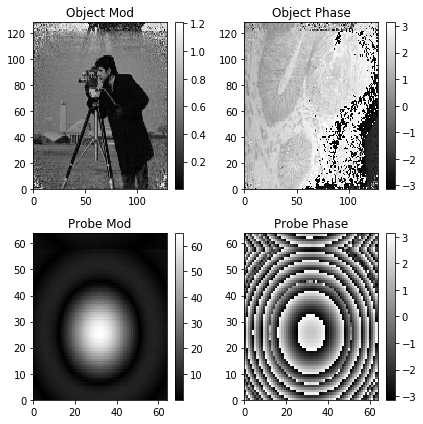

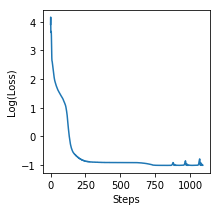

In [69]:
plt.figure(figsize=[6,6])
plot_items = [np.abs(recons_obj), np.angle(recons_obj),
              np.abs(recons_probe), np.angle(recons_probe)]
plot_titles = ['Object Mod', 'Object Phase', 'Probe Mod', 'Probe Phase']
for indx, item in enumerate(plot_items):
    plt.subplot(2, 2, indx + 1)
    plt.pcolormesh(item, cmap='gray')
    plt.colorbar()
    plt.title(plot_titles[indx])
plt.tight_layout()
plt.show()

plt.figure(figsize=[3,3])
plt.plot(np.log(lossvals_array))
plt.xlabel('Steps')
plt.ylabel('Log(Loss)')
plt.show()

In [70]:
# Calculating the reconstruction errors using the plane fitting procedure
# Note that the error thus calculated does not account for the lack of probe overlap at the edges of the object.
# Hence, the error calculated is an overestimate.
imgs, errs = registerImages(obj_true, recons_obj)
print('Reconstruction error', errs[1])


Reconstruction error 0.37005562877979603


/raid/home/skandel/anaconda3/envs/tensorflow17/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
